# ALI Performance Tests on Blake

## Introduction
Currently testing the Greenland Ice Sheet (GIS) and Antartica Ice Sheet (AIS) in Albany Land Ice (ALI) using Intel Skylake CPUs on blake.

### Architectures: 
| Name  | Blake (SKX) |
|---|---|
| CPU  | Dual-socket Intel<br/>Xeon Platinum 8160<br/>(Skylake) |
| Cores/Node  | 48  |
| Threads/Core  | 2 |
| Memory/Node  | 187 GB |
| Interconnect  | Intel OmniPath<br/>Gen-1 (100 GB/s)  |
| Compiler  | Intel 18.1.163  |
| MPI  | openmpi 2.1.2  |

### Cases: 
| Case Name  | Number of Processes (np) | Description |
|---|---|---|
| ant-2-20km_ml_ls | 384 | Unstructured 2-20km AIS, ML w/ line smoothing |
| ant-2-20km_mu_ls | 384 | Unstructured 2-20km AIS, MueLu w/ line smoothing |
| ant-2-20km_mu_dls | 384 | Unstructured 2-20km AIS, MueLu w/ decoupled line smoothing |
| greenland-1-7km_fea_1ws | 384 | Unstructured 1-7km GIS, finite element assembly only, single workset |
| greenland-1-7km_ml_ls_1ws | 384 | Unstructured 1-7km GIS, ML w/ line smoothing, single workset |
| greenland-1-7km_mu_ls_1ws | 384 | Unstructured 1-7km GIS, MueLu w/ line smoothing, single workset |
| greenland-1-7km_mu_dls_1ws | 384 | Unstructured 1-7km GIS, MueLu w/ decoupled line smoothing, single workset |
| greenland-1-7km_fea_mem | 384 | Unstructured 1-7km GIS, finite element assembly only, memoization |
| greenland-1-7km_ml_ls_mem | 384 | Unstructured 1-7km GIS, ML w/ line smoothing, memoization |
| greenland-1-7km_mu_ls_mem | 384 | Unstructured 1-7km GIS, MueLu w/ line smoothing, memoization |
| greenland-1-7km_mu_dls_mem | 384 | Unstructured 1-7km GIS, MueLu w/ decoupled line smoothing, memoization |

### Timers: 
| Timer Name | Level | Description |
|---|---|---|
| Albany Total Time | 0 | Total wall-clock time of simulation |
| Albany: Setup Time | 1 | Preprocess |
| Albany: Total Fill Time | 1 | Finite element assembly |
| Albany Fill: Residual | 2 | Residual assembly |
| Albany Residual Fill: Evaluate | 3 | Compute the residual, local/global assembly |
| Albany Residual Fill: Export | 3 | Update global residual across MPI ranks |
| Albany Fill: Jacobian | 2 | Jacobian assembly |
| Albany Jacobian Fill: Evaluate | 3 | Compute the Jacobian, local/global assembly |
| Albany Jacobian Fill: Export | 3 | Update global Jacobian across MPI ranks |
| NOX Total Preconditioner Construction | 1 | Construct Preconditioner |
| NOX Total Linear Solve | 1 | Linear Solve |

In [1]:
import datetime as dt
import glob
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import os

# Import scripts
from json2status import json2status
from json2timeline import json2timeline
from utils import *
from models import cusum


# Extract file names
files = glob.glob('ctest-*')

## Performance Tests Status

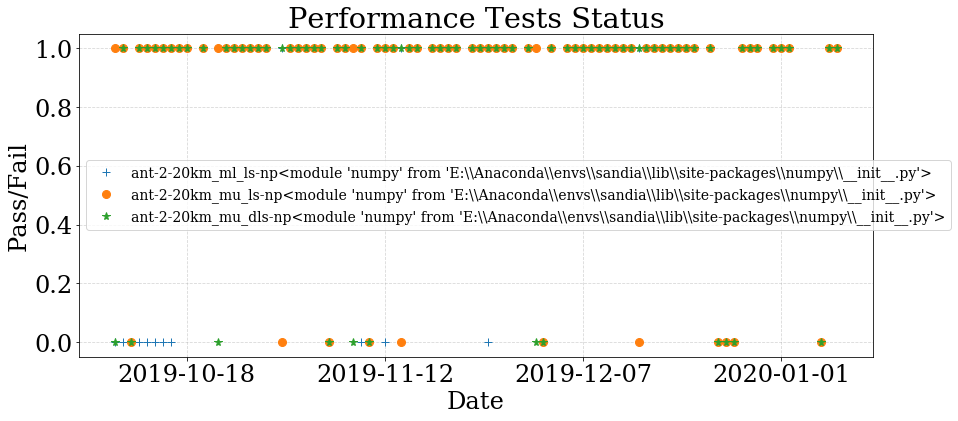

In [2]:
%matplotlib inline
#plt.rc('text', usetex=True)
plt.rc('font', family='serif', size=24)
plt.rcParams['figure.figsize'] = (14, 6)

# Cases to plot
cases = ('ant-2-20km_ml_ls',
         'ant-2-20km_mu_ls',
         'ant-2-20km_mu_dls')
nproc = 384

# Plot:
plt.figure()
imarker = 0
markers = ['+','o','*','x','v','d','^','s','>','<','+']
legNames = []
for case in cases:
    # Extract info and plot
    dates, status = json2status(files, case, nproc)
    fdates = [dt.datetime.strptime(str(d),'%Y%m%d').date() for d in dates]
    plt.plot(fdates, status, markersize=8.0, marker=markers[imarker], linestyle='None')
    imarker = imarker + 1
    legNames.append(case+'-np'+str(np))
        
plt.xlabel('Date')
plt.ylabel('Pass/Fail')
#plt.ylim((6e-3, 1e-1))
plt.legend(legNames,fontsize=14,loc='center left')
plt.tight_layout()
plt.title('Performance Tests Status')
ax = plt.gca()
ax.set_axisbelow(True)
ax.grid(linestyle='--', alpha=0.5)
ax.xaxis.set_major_locator(plt.MaxNLocator(5))
#ax.tick_params(axis='x',rotation = 45)
plt.show()


## Performance Timelines

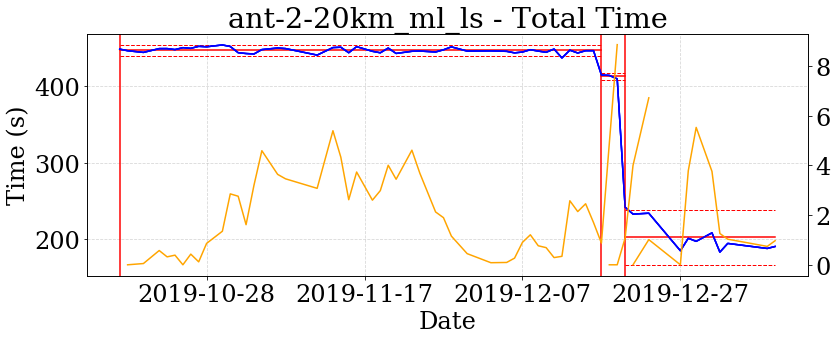

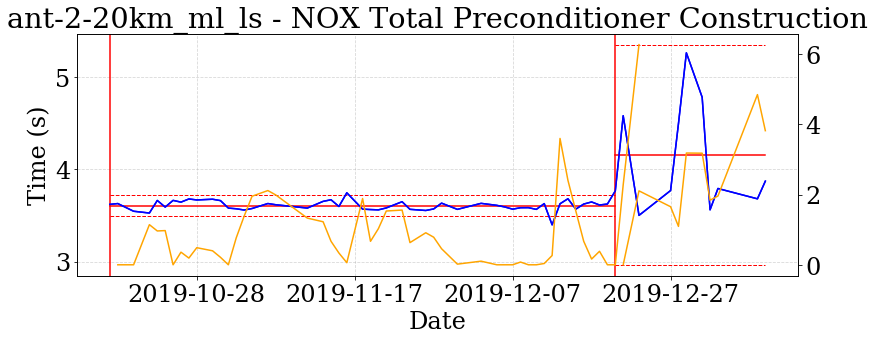

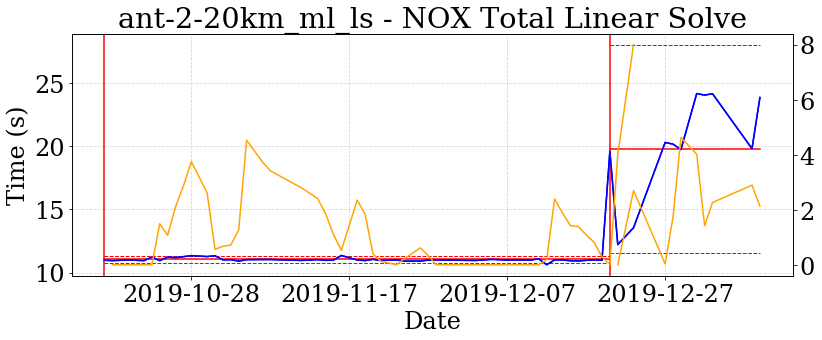

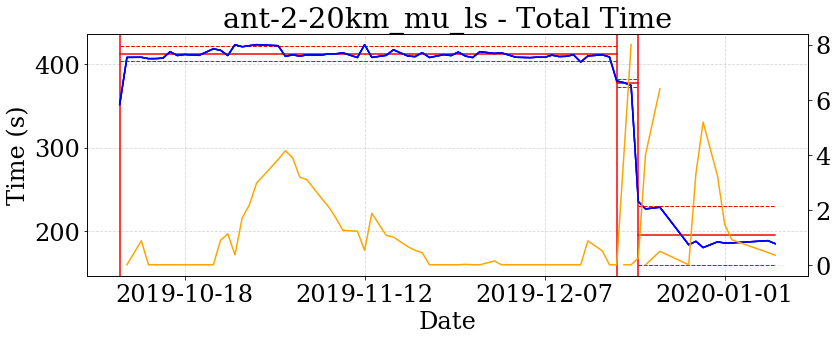

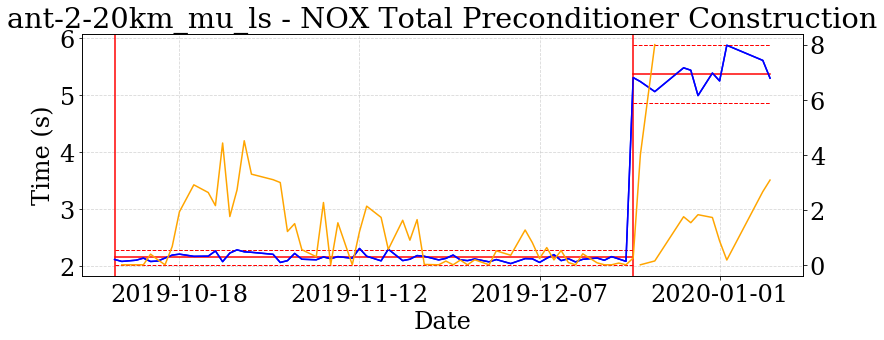

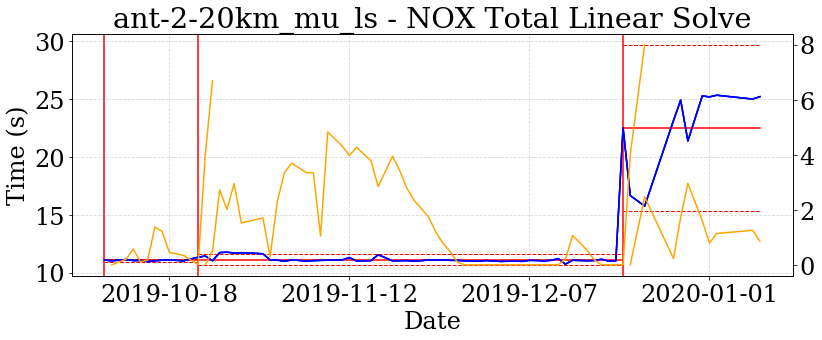

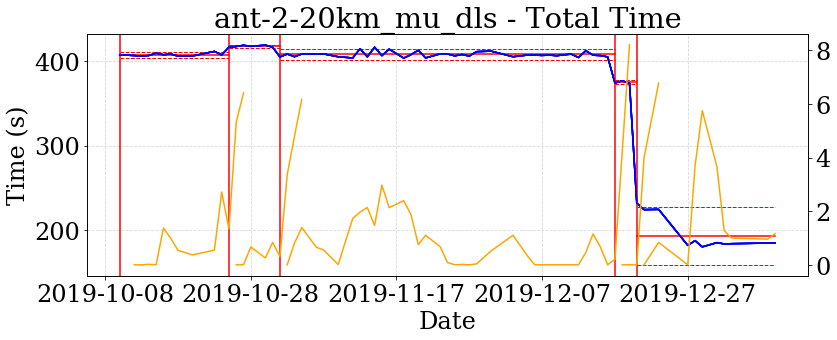

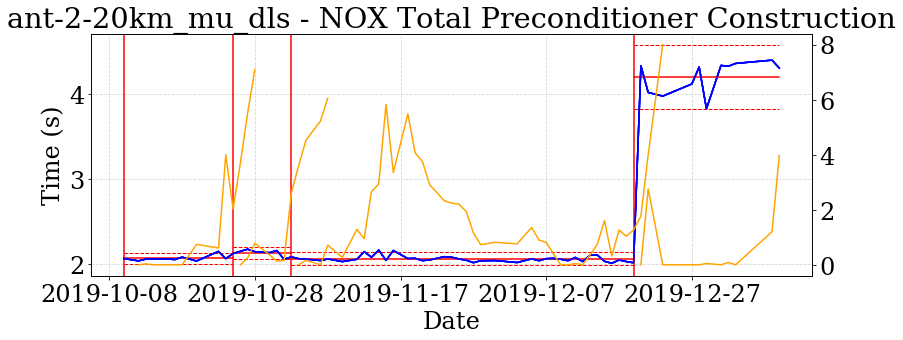

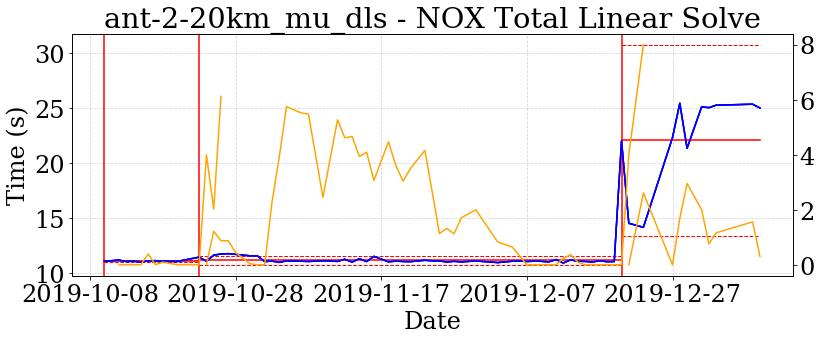

In [3]:
%matplotlib inline
#plt.rc('text', usetex=True)
plt.rc('font', family='serif', size=24)
plt.rcParams['figure.figsize'] = (12, 6)

# Cases to plot:
cases = ('ant-2-20km_ml_ls','ant-2-20km_mu_ls','ant-2-20km_mu_dls')
nproc = 384
names = ('Total Time',
#          'Total Fill Time',
         'NOX Total Preconditioner Construction',
         'NOX Total Linear Solve')
timers = ('Albany Total Time:',
#           'Albany: Total Fill Time:',
          'NOX Total Preconditioner Construction:',
          'NOX Total Linear Solve:')

# Plot:
for case in cases:
    for name, timer in zip(names, timers):
        dates, wtimes = json2timeline(files, case, nproc, timer, False)
        fdates = [dt.datetime.strptime(str(d),'%Y%m%d').date() for d in dates]

        # Run algorithm
        wtimes = np.array(wtimes)
        output, changePts = cusum(wtimes, verbose=0)
        
        # Make plot
        fig, ax1 = plt.subplots(figsize=(12,5))
        plt.xlabel('Date')
        plt.ylabel('Time (s)')
        plt.tight_layout()
        plt.title(case + ' - ' + name)
        
        plotRegimes(fdates, wtimes, changePts, ax1)
        
        ax2 = plt.twinx(ax1)
        for data in output['cusum']:
            ax2.plot(fdates, data, color='orange') 
            
        ax2.set_axisbelow(True)
        ax1.grid(linestyle='--', alpha=0.5)
        ax2.xaxis.set_major_locator(plt.MaxNLocator(5))
        plt.show()